In [2]:
import numpy as np

class Plane:
    def __init__(self, coef, b, plane_id = -1):
        norm = np.linalg.norm(coef)
        self.perp_vec = coef / norm
        self.b = b / norm
        self.dimension = coef.shape[0]
        self.plane_id = plane_id

        pt_on_plane = [0] * self.dimension
        for i, c in np.ndenumerate(coef):
            indx = i[0]
            if abs(c) > 1e-8:
                pt_on_plane[indx] = b / c
                break
        self.pt_on_plane = pt_on_plane

    def pt_in_half_plane(self, pt):
        return np.dot(pt, self.perp_vec) < self.b + 1e-8

    def pt_on_hyperplane(self, pt):
        diff = abs(np.dot(pt, self.perp_vec) - self.b)
        return diff < 1e-8

    def line_intersection(self, point, direction) :
        num = self.b - np.dot(point, self.perp_vec)
        denom = np.dot(direction, self.perp_vec)
        t = num / denom
        if t < -1e-8: t = 1e5
        return point + direction * t

    def projection(self, point):
        return self.line_intersection(point, 1 * self.perp_vec);

    def reflect(self, point, direction):
        # return self.reflect_function(point, direction)

        # move everything to origin
        intersection = self.line_intersection(point, direction)
        pp = point - self.pt_on_plane

        dd = direction

        # mirror the point across the hyperplane
        proj = self.perp_vec * np.dot(pp, self.perp_vec) \
               / np.dot(self.perp_vec, self.perp_vec)

        mirror = pp - 2 * proj + self.pt_on_plane
        direction = intersection - mirror

        direction = direction / np.linalg.norm(direction)

        return (intersection, direction)

class Ball:
    def __init__(self, center, radius, index):
        self.center = center
        self.radius = radius
        self.index = index

    def pt_inside(self, pt):
        dist = np.linalg.norm(pt - self.center)

        if dist < self.radius + 1e-8:
            return True
        return False

    def does_intersect(self, o, l) :
        c = self.center
        r = self.radius
        
        if np.dot(c - o, l) < 0: return False

        l = l / np.linalg.norm(l)

        a = - (np.dot(l, o - c))
        b = (np.dot(l, (o - c)) ** 2) - (np.linalg.norm(o - c) ** 2) + r*r
        return b >= -1e-8

    '''
    circle centered at c, of radius r
    line: x = o + d * l (origin o, direction l)
    '''
    def line_intersection(self, o, l):
        c = self.center
        r = self.radius

        l = l / np.linalg.norm(l)

        a = - (np.dot(l, o - c))
        b = (np.dot(l, (o - c)) ** 2) - (np.linalg.norm(o - c) ** 2) + r*r
        b = np.sqrt(b)

        d1 = a + b
        d2 = a - b

        p1 = o + d1 * l
        p2 = o + d2 * l

        if np.linalg.norm(p1 - o) < np.linalg.norm(p2 - o):
            return p1
        return p2

    def reflection(self, pt, direction):
        hit_on_sphere = self.line_intersection(pt, direction)

        perp = hit_on_sphere - self.center
        b = np.dot(perp, hit_on_sphere)
        plane = Plane(perp, b)

        p, d = plane.reflect(pt, direction)
        return p, d
    
    def angle(self, pt, direction): 
        v = pt - self.center
        v /= np.linalg.norm(v)
        d = direction / np.linalg.norm(direction)
        
        return np.arccos(np.dot(v, d))


In [3]:
def run(N, balls, index, pt, d, want_index = False): 
    
    indexes = []
    angles = []
    pts = []
    for _ in range(N): 
        
        dist = 1e9
        hit_ball = None
        for ball in balls: 
            if ball.index == index: 
                continue
                
            idx = -1
            if ball.does_intersect(pt, d): 
                hit = ball.line_intersection(pt, d)
                if np.linalg.norm(hit - pt) < dist: 
                    dist = np.linalg.norm(hit - pt)
                    hit_ball = ball
            
        index = hit_ball.index
        indexes.append(index)
        pt, d = hit_ball.reflection(pt, d)
                  
        pts.append(pt)
        angles.append(hit_ball.angle(pt, d))
        
    if want_index: 
        return pts, angles, indexes
    return pts, angles

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

def circ(x, y, r, phi):
    return (x + r * np.cos(phi), y + r*np.sin(phi))

def plot_circle(x, y, r, a = 0, b = np.pi * 2):
    phis = np.arange(a,b,0.01)
    plt.plot(*circ(x, y, r, phis), c = 'r')

    plt.xlim(-.5, .5)
    plt.ylim(-.5, .5)
    plt.gca().set_aspect('equal', adjustable='box')

def draw_balls(balls): 
    for ball in balls: 
        plot_circle(ball.center[0], ball.center[1], ball.radius)
        
def plot_orbit(pts): 
    for i in range(len(pts) - 1):
        plt.plot([pts[i][0], pts[i+1][0]], [pts[i][1], pts[i+1][1]], color = 'blue')

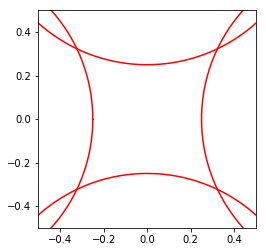

In [5]:

radius = 0.75
balls = [Ball(np.array([-1, 0]), radius, 0), Ball(np.array([1, 0]), radius, 1), Ball(np.array([0, -1]), radius, 2), Ball(np.array([0, 1]), radius, 3)]
# balls = [Ball(np.array([0, -8]), 1, 0), Ball(np.array([-100, 5]), 100, 1), Ball(np.array([100, 5]), 100, 2)]
# balls = [Ball(np.array([-1, 0]), radius, 0), Ball(np.array([0, -1]), radius, 1), Ball(np.array([5, 5]), 7.1, 2)]

res = run(1, balls, -1, np.array([-0.1,0]), np.array([0,1]))

plot_orbit(res[0])
draw_balls(balls)

In [8]:
n = 10
all_pts = []
all_angles = []
for i in np.arange(-0.1, 0.1, 1e-4): 
    pt = np.array([-0.2, i])
    pts, angles = run(n, balls, -1, pt, np.array([1, 0]))
    all_pts.append(pts)
    all_angles.append(angles)

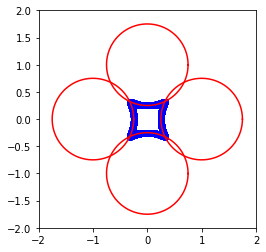

In [9]:
for pt in all_pts: 
    plt.scatter(pt[-1][0], pt[-1][1], color = 'blue')
draw_balls(balls)    
plt.figure(figsize=(30, 30))

In [131]:
true = np.array([0, -1 + radius])
all_pts = []

total = 0
cnt3 = 0
cnt4 = 0
cnt5 = 0
cnt6 = 0
close = 0
for a in np.arange(-1e-5, 1e-5, 1e-7):
    for b in np.arange(-1e-5, 1e-5, 1e-7):
        angle = (np.pi / 4) + b
        
        st = np.array([a, -1 + radius])
        d = np.array([np.tan(angle),1])
        
        pts, angles = run(4, balls, 2, st, d)
        last = pts[-1]
        
        d = np.linalg.norm(last - true)
        
        if d < 2*np.linalg.norm(st - true):
            close += 1
#             all_pts.append((st, angle))
      
        if d < 1e-3:
            cnt3 += 1;
        if d < 1e-4:
            cnt4 += 1;
        if d < 1e-5:
            cnt5 += 1;
            all_pts.append((st, angle))
        if d < 1e-6:
            cnt6 += 1;
        total += 1

# for i in range(len(pts) - 1):
#     plt.plot([pts[i][0], pts[i + 1][0]], [pts[i][1], pts[i + 1][1]], color = 'blue')
# draw_balls(balls)

In [132]:
print(cnt3, total, cnt3 * 1.0 / total)
print(cnt4, total, cnt4 * 1.0 / total)
print(cnt5, total, cnt5 * 1.0 / total)
print(cnt6, total, cnt6 * 1.0 / total)
print(close, total, close * 1.0 / total)

40401 40401 1.0
19065 40401 0.4718942600430682
1959 40401 0.04848889878963392
194 40401 0.00480186134006584
1508 40401 0.037325808767109725


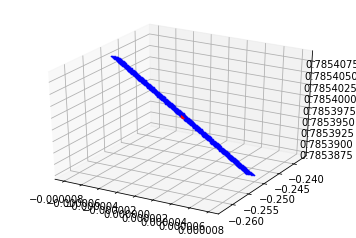

In [133]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for p in all_pts: 
    ax.scatter(p[0][0], p[0][1], p[1], color = 'blue', s = 0.2)
ax.scatter(true[0], true[1], np.pi/4, color = 'red')

(-0.2501, -0.2499)

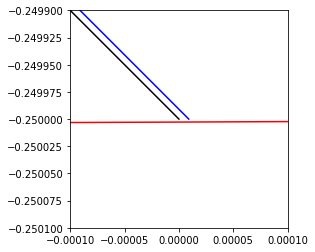

In [109]:
cur = all_pts[400]
d = np.array([np.tan(cur[1]),1])
cur, _ = run(4, balls, 2, cur[0], d)
for i in range(len(cur) - 1): 
    plt.plot([cur[i][0], cur[i+1][0]], [cur[i][1], cur[i + 1][1]], color = 'blue')

cur = true
d = np.array([1,1])
cur, _ = run(4, balls, 2, cur, d)
for i in range(len(cur) - 1): 
    plt.plot([cur[i][0], cur[i+1][0]], [cur[i][1], cur[i + 1][1]], color = 'black')

    
draw_balls(balls)

x = 0
y = -(1 - radius)

eps = 1e-4
plt.xlim(x - eps, x + eps)
plt.ylim(y - eps, y + eps)

In [9]:
start = np.array([0, -1 + radius])
angle = np.pi / 3.0
d = np.array([np.tan(angle),1])

pts, angs = run(100000, balls, 2, start, d)
n = 0     

DONE


In [17]:
eps = 1e-2
n = 0
best_a = 10
for p, a in zip(pts[1:], angs[1:]): 
    n += 1
    if np.linalg.norm(p - pts[0]) < eps : 
        best_a = min(best_a, abs(angs[0] - a))
        print(n, abs(angs[0] - a))

76 0.319253636614
192 0.308859611668
303 0.0873665748348
314 0.35492122601
574 0.457022851441
596 0.853813186912
615 0.622424446918
722 0.52672630715
852 0.12335660837
1001 0.046965124845
1070 0.127031716972
1446 0.0912503709894
1713 0.424172502079
1862 0.426154697934
2118 0.36581624721
2213 0.323374550937
2444 0.115251340539
2576 0.87483650618
2624 0.513630130496
2952 0.00275974386745
3075 0.0636844489052
3080 1.05448428119
3213 0.27946451232
3250 0.325321615776
3304 0.353367581705
3491 0.588100819616
3573 0.422534661728
3731 0.555625997364
3742 0.610275106157
4196 0.0529315406566
4262 0.201817382429
4513 0.276810161196
4801 0.0932724228383
5051 0.333378986552
5441 0.0517239087344
5530 0.316188469349
5679 0.575767979969
5689 0.000563093445541
5712 0.99464108907
5790 0.300361798859
5809 0.00325385168222
5851 0.221268050387
6112 0.383332389834
6297 0.886147911688
6307 0.679864282105
6578 0.0366606148651
6782 0.638520713811
6896 0.15237826144
6898 0.158031252815
6910 0.0620155275371
6982

79999 0.262481906737
80235 0.226424023197
80301 0.226593842648
80361 0.0829006867217
80592 0.762271038524
80744 0.309249587865
80768 0.0156027252584
80785 0.251660774046
80947 0.53059364835
81312 0.726883521519
81502 0.172014727038
81512 0.63652895626
81668 0.516651686173
82040 0.0732349764975
82104 0.392922131662
82188 0.356321546242
82229 0.249505892212
82522 0.162106279984
82677 0.170448697165
82794 0.0212983574745
82968 0.0950810627078
83042 0.181476663641
83128 0.293490813065
83480 0.335014242765
83489 0.444533117324
83654 0.0315702778145
84078 0.387220586827
84083 0.339313107866
84313 0.373048167978
84397 0.0639313189729
84423 0.402212278693
84589 0.367858352291
84790 0.357709042403
84905 0.449117778852
85015 0.628219253533
85083 0.184377406904
85223 0.823880864074
85247 0.129749733577
85424 0.357808750833
85471 0.0493823746933
85605 0.682248261066
85814 0.225943657024
85895 0.0135534564365
86007 0.363480994606
86136 0.631761131017
86172 0.592864635351
86193 0.41347232481
86337 0

In [7]:
eps = 1e-2
amnt = 0
total = 0
frac = [0] * 2010
for a in np.arange(-1e-2, 1e-2, 1e-3):
    for b in np.arange(-1e-1, 1e-1, 1e-2):
        total += 1
        
        angle = (np.pi / 3) + b
        
        st = np.array([a, -1 + radius])
        d = np.array([np.tan(angle),1])

        pts, angles = run(2010, balls, 2, st, d)
        
        for i in range(1, len(pts)): 
            if np.linalg.norm(pts[i] - st) < eps and abs(angles[i] - angle) < 1e-1:
                frac[i] += 1
                amnt += 1
#                 best_a = min(best_a, abs(angles[i] - angle))
                print(amnt, abs(angles[i] - angle), i)
                break
print(amnt, total, amnt * 1.0 / total)
print(best_a)

1 0.0915982425796 1140
2 0.0303651988765 1913
3 0.0442620945833 1298
4 0.0438676585635 1874
5 0.0252562854576 674
6 0.0690613213466 658
7 0.0628866323503 524
8 0.0714215392975 1022
9 0.053754624555 652
10 0.0513511813523 1662
11 0.0178294690657 77
12 0.00388292166973 1178
13 0.00564190979638 697
14 0.0556709619496 617
15 0.0901457549458 702
16 0.0270187914775 3
17 0.00772197348622 66
18 0.082837989979 378
19 0.0870534508825 696
20 0.0797837002035 67
21 0.0536932165344 1306
22 0.0719341798787 781
23 0.0847290137419 454
24 0.030167361298 173
25 0.0240799268193 1863
26 0.0705974409669 212
27 0.0593120100122 572
28 0.0219243639976 713
29 0.0696655256315 1373
30 0.0414455954278 671
31 0.00682858055192 3
32 0.0607632289363 773
33 0.0748042091046 136
34 0.0138309304488 970
35 0.0617851112575 1171
36 0.0961174948067 338
37 0.00391692475632 474
38 0.012686068279 1400
39 0.025639710998 403
40 0.0933742225704 444
41 0.0569119455825 415
42 0.03588537881 50
43 0.0351537281741 122
44 0.0383516133449

NameError: name 'best_a' is not defined

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
    
# for pt, angle in zip(all_pts, all_angles): 
#     if balls[0].pt_inside(pt[-1]):
#         ax.scatter(pt[-1][0], pt[-1][1], angle[-1] - np.pi / 2, color = 'blue')

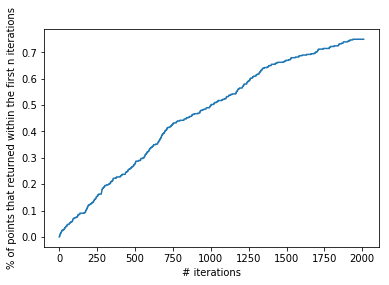

In [8]:
f = []
f.append(frac[0] / 400.0)
for i in range(1,len(frac)): 
    f.append((f[-1] + frac[i] / 400.0))
plt.plot(range(len(f)), f)
plt.xlabel("# iterations")
plt.ylabel("% of points that returned within the first n iterations")
plt.show()

In [9]:
print(f[100])
print(f[200])
print(f[400])
print(f[800])
print(f[1000])
print(f[2000])

0.07250000000000002
0.12250000000000007
0.22750000000000015
0.44250000000000034
0.4975000000000004
0.7499999999999956


In [12]:
# plot_circle(balls[0].center[0], balls[0].center[1], balls[0].radius, -0.4, 0.3)
# plot_circle(balls[1].center[0], balls[1].center[1], balls[1].radius, 1.3, 1.9)
# plot_circle(balls[2].center[0], balls[2].center[1], balls[2].radius, 3.88, 3.98)

In [13]:
# cols = ['red', 'green', 'blue']
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# boundary = [circ(balls[0].center[0], balls[0].center[1], balls[0].radius, np.arange(-0.4, 0.3, 1e-1))]
# for i in range(len(boundary)):
#     for pt in zip(boundary[i][0], boundary[i][1]): 
#         for a in np.arange(-np.pi / 2, np.pi/2, 1e-1): 
#             n = pt - balls[i].center
#             d = np.array([np.cos(a) * n[0] - np.sin(a) * n[1], np.sin(a) * n[0] - np.cos(a) * n[1]])
            
#             res = run(1, balls, balls[i].index, np.array(pt), np.array(d), want_index = True)
#             ax.scatter(pt[0], pt[1], a, color = cols[res[2][-1]])